# Applying BB AW-SGD to Non - Linear Regression

In this notebook, I will compare stochastic gradient descent to weighted stochastic gradient descent on the problem of non-linear regression. I will first investigate kernel regression (perhaps with regularisation).

The aims of the experiment:

* To see if there is any speed - up using adaptive weighting.
* If there is a speed - up to quantify it.
* If there isn't a speed-up to understand why

The output of the experiment should be:

* learning rate curves for test and training data for both algorithms whith the best cross-validated learning rate on some simulated data.

* If this is promising, learning rate curves on some real data.

## The Mathematics:

Our model is : $ y = w^\top \phi(x) + \eta$ where $\phi(x)$ is a high dimensional feature - map and $\eta$ is zero mean gaussian noise.

The negative logliklihood of the paramters is given by: $ - log(P(x|w)) = \frac{1}{2} (\Phi w - Y)^\top(\Phi w - Y)$.
Where $\Phi$ is the design matrix and $Y$ is a vector of regression values. If we place a gaussian prior on $w$ this acts as a regulariser and gives an objective function: $\gamma(w) = \frac{1}{2} (\Phi w - Y)^\top(\Phi w - Y) + \lambda w^\top w$



$ \gamma(\alpha) = \alpha^\top KK \alpha - 2 Y^\top K \alpha + Y^\top Y + \alpha^\top K \alpha$ where $K = \Phi \Phi^\top $ is the kernel matrix.

This is the objective that we will aim to optimise. Differentiating Directly would give that $\alpha = (K+\lambda I)^{-1} Y$ but for large data sets, inverting $K$ is $O(n^3)$ and so becomes infeasible and iterative methods are neccesary.


### SGD:

The standard SGD Updates would be :

\begin{equation}
w_{t+1} = w_t - \mu [(f_t(x) - y_t)\phi(x_t) + \lambda w_t]
\end{equation}

where:

\begin{equation}
f_{t+1}(x) = \phi(x)^\top w_t - \mu[(f_t(x) - y_t)K(x_t,x) + \lambda f_t(x)] = (1-\mu \lambda)f_t(x) - \mu(f_t(x_t) - y_t)K(x_t,x)
\end{equation}

We cant use these equactions directly because the feature map maybe infinite dimensional but the representer theorem tells us that we can write $ w = \Phi^\top \alpha$ and so the second equation becomes:

\begin{equation}
\sum_i^{t+1} \alpha_i K(x_t,x) = (1-\lambda \mu)\sum_i^t \alpha_i K(x_t,x) - \mu(f_t(x) - y_t)K(x_t,x)
\end{equation}

Equating co-efficients we get the following update equation for $\alpha$:

\begin{equation}
\alpha_{t+1} =   \begin{bmatrix}
          (1 -\mu \lambda) \alpha_t \\
           - \mu(f_t(x_t) - y_t)
         \end{bmatrix}
\end{equation}

i.e a new component of alpha is added at each stage but the resulting alpha vector is still dependent on the order in which the samples are added.

### BB AW - SGD:

For the BB AW-SGD version of these equations we also keep track of a sampling paramter $\tau$ which is drawn from a gaussian and index chosen by rounding the sample to the nearest whole number. Call the sampling distribution $Q_\tau(i)$

The update for $\alpha_t$ is now:


\begin{equation}
\alpha_{t+1} =   \begin{bmatrix}
         (1- \frac{ \mu \lambda }{Q_\tau^(t)})\alpha_t \\
           \frac{- \mu(f_t(x_t) - y_t)}{Q_\tau^(t)}
         \end{bmatrix}
\end{equation}
The update for $\tau$ is: 

\begin{equation}
\tau_{t+1} = \tau + \epsilon (\frac{(f_t(x_t) - y_t)^2}{Q_\tau(t)^2} - baseline)(z - \tau)
\end{equation}

and the baseline is a moving average of $\frac{(f_t(x_t) - y_t)^2}{Q_\tau(t)^2}$.








## Implementing the Experiments

For the following experiments I will use either a gaussian kernel or polynomial kernel troughout:
 

## Test 1: Linear Data with a Linear Kernel

In the first experiment I use linear data with a linear Kernel simply to ensure that everything is working as expected.

In [1]:
%matplotlib inline
from non_linear_sgd import * # Import all the relevent dependencies

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Generate Linear Data
N,D,sigma = 100,1,0.1
w_true, X, y = gen_data_linear(N,D,sigma)

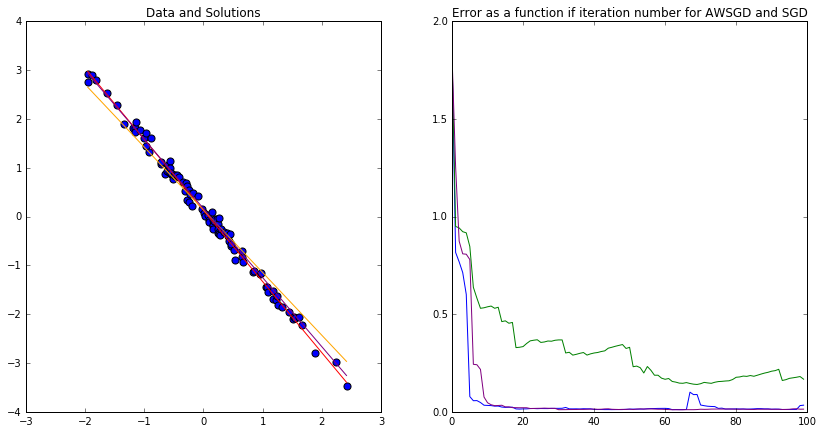

In [3]:
# solve
K_nrml,alpha_nrml = kernel_ridge_normal(X,y,0.01,np.dot) # solve using the normal equations
K_sgd,alpha_sgd,errors_sgd = kernel_regression_with_sgd(X,y,linear_kernel,0.1,0.01,N) # solve using sgd
K_awsgd,alpha_awsgd,errors_awsgd = kernel_regression_with_awsgd(X,y,[],[],linear_kernel,0.001,1e-8,
                                                                0.1,N,base_line = 0.0) # solve using awsgd
K_min,alpha_min,errors_min = kernel_regression_with_minvar(X,y,linear_kernel,0.1,0.01,N) #solve using minvar sgd

# Get the predictions on the training data
Y_est_nrml = np.dot(K_nrml.T,alpha_nrml)
Y_est_sgd = np.dot(K_sgd.T,alpha_sgd)
Y_est_awsgd = np.dot(K_awsgd.T,alpha_awsgd)
Y_est_min = np.dot(K_min.T,alpha_min)

# Plot the data
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.scatter(X[:, 0], y, s=50)
#Plot real line
plt.plot(X[:, 0], np.dot(X, w_true), color='r')
plt.title('Data and Solutions')
plt.hold
#Plot the two estimates
#plt.plot(X[:, 0], Y_est_nrml, color='g')
plt.plot(X[:, 0], Y_est_sgd, color='orange')
#plt.plot(X[:, 0], Y_est_awsgd, color='purple')
plt.plot(X[:, 0], Y_est_min, color='purple')
plt.subplot(1,2,2)
plt.title('Error as a function if iteration number for AWSGD and SGD')
plt.plot(errors_sgd,color = 'blue')
plt.plot(errors_awsgd,color = 'green')
plt.plot(errors_min,color = 'purple')
plt.show()

   ## Test 2: Polynomial Data with a Polynomial Kernel

In [4]:
# Generate Quadratic Data
N,D,sigma = 100,1,0.5 # Set number of data dimensions and noise
X,Y,Y_true = gen_data_non_linear(N,D,sigma)

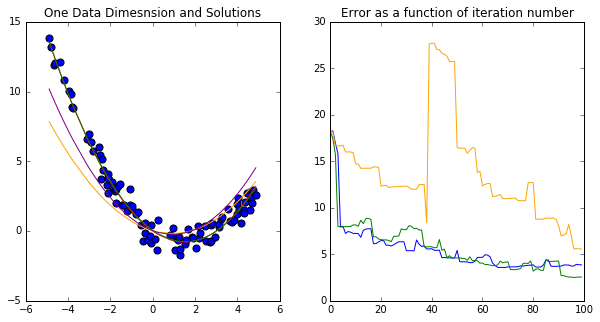

In [6]:
#Solve
K_nrml,alpha_nrml = kernel_ridge_normal(X,Y,0.01,polynomial_kernel) # Solve Using the Normal Equations
K_sgd,alpha_sgd,errors_sgd = kernel_regression_with_sgd(X,Y,polynomial_kernel,0.001,0.01,N) # solve using sgd
K_awsgd,alpha_awsgd,errors_awsgd = kernel_regression_with_awsgd(X,Y,[],[],polynomial_kernel,0.00001,1e-7,
                                                                0.01,N,base_line = 0.01) # solve using awsgd

K_min,alpha_min,errors_min = kernel_regression_with_minvar(X,Y,polynomial_kernel,0.001,0.01,N) #solve using minvar sgd

Y_est_nrml = np.dot(K_nrml,alpha_nrml)
Y_est_sgd = np.dot(K_sgd,alpha_sgd)
#Y_est_awsgd = np.dot(K_awsgd,alpha_awsgd)
Y_est_min = np.dot(K_min,alpha_min)

# Plot the data
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.scatter(X[:, 0], Y, s=50)
# Plot real line
plt.plot(X[:, 0], Y_true, color='r')
plt.title('One Data Dimesnsion and Solutions')
plt.hold
# Plot the two estimates
plt.plot(X[:, 0], Y_est_nrml, color='g')
plt.plot(X[:, 0], Y_est_sgd, color='orange')
plt.plot(X[:, 0], Y_est_min, color='purple')
plt.subplot(1,2,2)
plt.title('Error as a function of iteration number')
plt.plot(errors_sgd,color = 'blue')
plt.hold
plt.plot(errors_min,color = 'green')
plt.plot(errors_awsgd,color = 'orange')
plt.show()




The above graph shows that the solution found using SGD is not as accurate as the solution found using the normal equations. I suspect this is because I'm using a constant learning rate and so am not converging totally.

## Test 3: Polynomial Data with a Gaussian Kernel

In [78]:
# Generate Quadratic Data
N,D,sigma = 50,1,0.1
X,Y,Y_true = gen_data_non_linear(N,D,sigma)

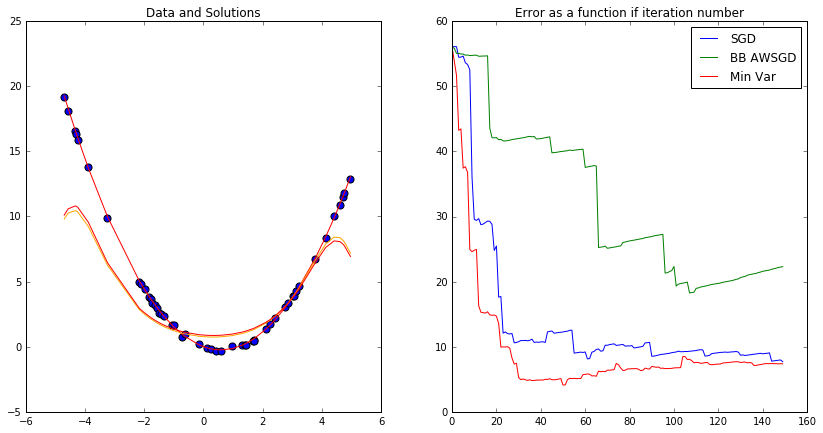

In [82]:
#Solve
K_nrml,alpha_nrml = kernel_ridge_normal(X,Y,0.01,gaussian_kernel) # Solve Using the Normal Equations
K_sgd,alpha_sgd,errors_sgd = kernel_regression_with_sgd(X,Y,gaussian_kernel,0.2,0.01,150) # solve using sgd
K_awsgd,alpha_awsgd,errors_awsgd = kernel_regression_with_awsgd(X,Y,[],[],gaussian_kernel,0.001,1e-8,
                                                                0.1,150,base_line = 0.0) # solve using awsgd

K_min,alpha_min,errors_min = kernel_regression_with_minvar(X,Y,gaussian_kernel,0.2,0.01,150) #solve using minvar sgd


Y_est_nrml = np.dot(K_nrml.T,alpha_nrml)
Y_est_sgd = np.dot(K_sgd.T,alpha_sgd)
Y_est_awsgd = np.dot(K_awsgd.T,alpha_awsgd)
Y_est_min = np.dot(K_min.T,alpha_min)

# Plot the data
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.scatter(X[:, 0], Y, s=50)
# Plot real line
plt.plot(X[:, 0], Y_true, color='r')
plt.title('Data and Solutions')
plt.hold
# Plot the two estimates
#plt.plot(X[:, 0], Y_est_nrml, color='g')
plt.plot(X[:, 0], Y_est_sgd, color='orange')
#plt.plot(X[:, 0], Y_est_awsgd, color='purple')
plt.plot(X[:, 0], Y_est_min, color='r')
plt.subplot(1,2,2)
plt.title('Error as a function if iteration number')
sgd, = plt.plot(errors_sgd,color = 'blue')
bb, = plt.plot(errors_awsgd,color = 'green')
minv, = plt.plot(errors_min,color = 'red')
plt.legend([sgd,bb,minv],['SGD','BB AWSGD','Min Var'])
plt.show()


## Test 4: More Complex Non-Linear Data

In the following tests I use the famous boston housing data-set: https://archive.ics.uci.edu/ml/datasets/Housing

In [3]:
# Get the Boston Housing Data
Data = np.loadtxt('Data/housing.data.txt')
labels = Data[:,13]
attr = Data[:,[0,1,2,4,5,6,7,8,9,10,11,12]]
#attr = np.sort(attr,0)
labels = np.reshape(labels,(506,1))

In [55]:
# Fit Using all dimesions and using both sgd and awsgd
K_sgd,alpha_sgd,errors_sgd = kernel_regression_with_sgd(attr,labels,gaussian_kernel,0.1,0.01,1000) # solve using sgd
#K_awsgd,alpha_awsgd,errors_awsgd = kernel_regression_with_awsgd(attr,labels,[],[],gaussian_kernel,0.001,2e-10,
 #                                                              0.01,1000,base_line = 0.0) # solve using awsgd

K_min,alpha_min,errors_min = kernel_regression_with_minvar(attr,labels,gaussian_kernel,0.1,0.01,1000) #solve using minvar sgd

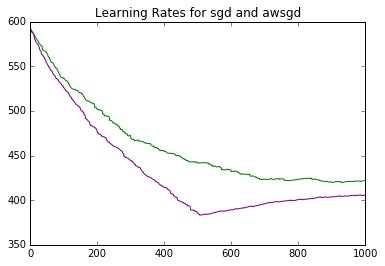

In [56]:
plt.plot(errors_sgd,color = 'green')
plt.hold
#plt.plot(errors_awsgd,color = 'blue')
plt.plot(errors_min,color = 'purple')
plt.title('Learning Rates for sgd and awsgd')

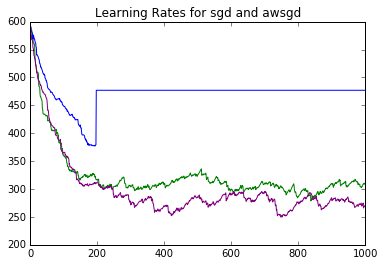

In [38]:
plt.plot(errors_sgd,color = 'green')
plt.hold
plt.plot(errors_awsgd,color = 'blue')
plt.plot(errors_min,color = 'purple')
plt.title('Learning Rates for sgd and awsgd')

# Cross Validating the Parameters

ToDo:
* edit the original functions so that they can give an error on a test-set as well as the training error
* write functions to automatically cross-validate the learning rates and the regularisation strength
* Change the learning rates to be of the form $\frac{\lambda_0}{1+t}$

In [46]:
num_iter = 1000
errors_sgd = np.zeros((num_iter,10))
errors_bb = np.zeros((num_iter,10))
errors_min = np.zeros((num_iter,10))

for i in range(10):
    K_sgd,alpha_sgd,errors_sgd[:,i:i+1] = kernel_regression_with_sgd(attr,labels,gaussian_kernel,1,0.01,1000) # solve using sgd
    K_awsgd,alpha_awsgd,errors_bb[:,i:i+1] = kernel_regression_with_awsgd(attr,labels,[],[],gaussian_kernel,0.001,2e-10,
                                                               0.01,1000,base_line = 0.0) # solve using awsgd
    K_min,alpha_min,errors_min[:,i:i+1] = kernel_regression_with_minvar(attr,labels,gaussian_kernel,1,0.01,1000) #solve using minvar sgd

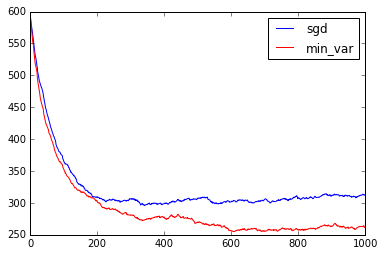

In [49]:
sgd_plot, = plt.plot(np.mean(errors_sgd,1))
plt.hold
min_plot, = plt.plot(np.mean(errors_min,1),color = 'red')
plt.legend([sgd_plot,min_plot],['sgd','min_var'])
#plt.plot(np.mean(errors_bb,1),color = 'green')

In [6]:
np.reshape?